# Поиск по изображениям.
В фотохостинге для профессиональных фотографов «Со Смыслом» пользователи размещают свои фотографии на хостинге и сопровождают их полным описанием: указывают место съёмок, модель камеры и т. д.
Необходимо разработать демонстрационную версию поиска изображений по запросу.

Для демонстрационной версии требуется модель, которая получит векторное представление изображения, векторное представление текста, а на выходе выдаст число от 0 до 1 — покажет, насколько текст и картинка подходят друг другу.

**Описание данных:**  
В файле train_dataset.csv собрана информация, необходимая для обучения: имя файла изображения, идентификатор описания и текст описания. Для одной картинки может быть доступно до 5 описаний. Идентификатор описания имеет формат <имя файла изображения>#<порядковый номер описания>.

В папке train_images содержатся изображения для тренировки модели.

В файле CrowdAnnotations.tsv — данные по соответствию изображения и описания, полученные с помощью краудсорсинга. Номера колонок и соответствующий тип данных:

    Имя файла изображения.
    Идентификатор описания.
    Доля людей, подтвердивших, что описание соответствует изображению.
    Количество человек, подтвердивших, что описание соответствует изображению.
    Количество человек, подтвердивших, что описание не соответствует изображению.

В файле ExpertAnnotations.tsv содержатся данные по соответствию изображения и описания, полученные в результате опроса экспертов. Номера колонок и соответствующий тип данных:

    Имя файла изображения.
    Идентификатор описания.
    3, 4, 5 — оценки трёх экспертов.

Эксперты ставят оценки по шкале от 1 до 4, где 1 — изображение и запрос совершенно не соответствуют друг другу, 2 — запрос содержит элементы описания изображения, но в целом запрос тексту не соответствует, 3 — запрос и текст соответствуют с точностью до некоторых деталей, 4 — запрос и текст соответствуют полностью.

В файле test_queries.csv находится информация, необходимая для тестирования: идентификатор запроса, текст запроса и релевантное изображение. Для одной картинки может быть доступно до 5 описаний. Идентификатор описания имеет формат <имя файла изображения>#<порядковый номер описания>.

В папке test_images содержатся изображения для тестирования модели.

## 1. Исследовательский анализ данных.

Импорт необходимых библиотек:

In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import GroupShuffleSplit

import torch
import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from torchvision.models import resnet50, ResNet50_Weights
from torchvision.models.feature_extraction import create_feature_extractor
from torchvision.io import read_image
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn

from pathlib import Path
from tqdm import tqdm

from transformers import AutoTokenizer, AutoModel

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

import matplotlib.pyplot as plt
from PIL import Image

In [2]:
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('punkt_tab')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [3]:
TRAIN_IMAGE_FOLDER = '/content/drive/MyDrive/overall_project_4/train_images'
TEST_IMAGE_FOLDER = '/content/drive/MyDrive/overall_project_4/test_images'
RANDOM_STATE = 42

### 1.1 Загрузка данных.

Загрузка данных, необходимых для обучения:

In [4]:
df_train = pd.read_csv('/content/drive/MyDrive/overall_project_4/train_dataset.csv')
display(df_train.head())
df_train.info()

,image,query_id,query_text
0,1056338697_4f7d7ce270.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...
1,1262583859_653f1469a9.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...
2,2447284966_d6bbdb4b6e.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...
3,2549968784_39bfbe44f9.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...
4,2621415349_ef1a7e73be.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5822 entries, 0 to 5821
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   image       5822 non-null   object
 1   query_id    5822 non-null   object
 2   query_text  5822 non-null   object
dtypes: object(3)
memory usage: 136.6+ KB


Загрузка информации по соответствию изображения и описания, полученные с помощью краудсорсинга:

In [5]:
df_crowd = pd.read_csv('/content/drive/MyDrive/overall_project_4/CrowdAnnotations.tsv', sep='\t',
                       header=None, names=['image', 'query_id', 'positive', 'n_conf', 'n_not_conf'])
display(df_crowd.head())
df_crowd.info()

,image,query_id,positive,n_conf,n_not_conf
0,1056338697_4f7d7ce270.jpg,1056338697_4f7d7ce270.jpg#2,1.0,3,0
1,1056338697_4f7d7ce270.jpg,114051287_dd85625a04.jpg#2,0.0,0,3
2,1056338697_4f7d7ce270.jpg,1427391496_ea512cbe7f.jpg#2,0.0,0,3
3,1056338697_4f7d7ce270.jpg,2073964624_52da3a0fc4.jpg#2,0.0,0,3
4,1056338697_4f7d7ce270.jpg,2083434441_a93bc6306b.jpg#2,0.0,0,3


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47830 entries, 0 to 47829
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   image       47830 non-null  object 
 1   query_id    47830 non-null  object 
 2   positive    47830 non-null  float64
 3   n_conf      47830 non-null  int64  
 4   n_not_conf  47830 non-null  int64  
dtypes: float64(1), int64(2), object(2)
memory usage: 1.8+ MB


Загрузка информации по соответствию изображения и описания, полученные в результате опроса экспертов:

In [6]:
df_expert = pd.read_csv('/content/drive/MyDrive/overall_project_4/ExpertAnnotations.tsv', sep='\t',
                       header=None, names=['image', 'query_id', 'mark_1', 'mark_2', 'mark_3'])
df_expert.reset_index(inplace=True, drop=True)
display(df_expert.head())
df_expert.info()

,image,query_id,mark_1,mark_2,mark_3
0,1056338697_4f7d7ce270.jpg,2549968784_39bfbe44f9.jpg#2,1,1,1
1,1056338697_4f7d7ce270.jpg,2718495608_d8533e3ac5.jpg#2,1,1,2
2,1056338697_4f7d7ce270.jpg,3181701312_70a379ab6e.jpg#2,1,1,2
3,1056338697_4f7d7ce270.jpg,3207358897_bfa61fa3c6.jpg#2,1,2,2
4,1056338697_4f7d7ce270.jpg,3286822339_5535af6b93.jpg#2,1,1,2


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5822 entries, 0 to 5821
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   image     5822 non-null   object
 1   query_id  5822 non-null   object
 2   mark_1    5822 non-null   int64 
 3   mark_2    5822 non-null   int64 
 4   mark_3    5822 non-null   int64 
dtypes: int64(3), object(2)
memory usage: 227.6+ KB


### 1.2 Работа с признаками.

Обработка результатов экспертов:

In [7]:
# Получение средней оценки экспертов
def get_experts_avg(row):
  array = [row['mark_1'], row['mark_2'], row['mark_3']]
  u, c = np.unique(array, return_counts=True)
  y = u[c == c.max()]
  return row[['mark_1', 'mark_2', 'mark_3']].mean()


# Получение доли экспертов, которые признали соответствие текста и изображения
def get_experts_positive(row):
  k = 0
  for mark in row[['mark_1', 'mark_2', 'mark_3']]:
    if mark >= 3:
      k += 1
  return k/3

In [8]:
df_expert['mark_avg'] = df_expert.apply(get_experts_avg, axis = 1)
df_expert['positive'] = df_expert.apply(get_experts_positive, axis = 1)
df_expert.head(20)

,image,query_id,mark_1,mark_2,mark_3,mark_avg,positive
0,1056338697_4f7d7ce270.jpg,2549968784_39bfbe44f9.jpg#2,1,1,1,1.000000,0.000000
1,1056338697_4f7d7ce270.jpg,2718495608_d8533e3ac5.jpg#2,1,1,2,1.333333,0.000000
2,1056338697_4f7d7ce270.jpg,3181701312_70a379ab6e.jpg#2,1,1,2,1.333333,0.000000
3,1056338697_4f7d7ce270.jpg,3207358897_bfa61fa3c6.jpg#2,1,2,2,1.666667,0.000000
4,1056338697_4f7d7ce270.jpg,3286822339_5535af6b93.jpg#2,1,1,2,1.333333,0.000000
5,1056338697_4f7d7ce270.jpg,3360930596_1e75164ce6.jpg#2,1,1,1,1.000000,0.000000
6,1056338697_4f7d7ce270.jpg,3545652636_0746537307.jpg#2,1,1,1,1.000000,0.000000
7,1056338697_4f7d7ce270.jpg,434792818_56375e203f.jpg#2,1,1,2,1.333333,0.000000
8,106490881_5a2dd9b7bd.jpg,1425069308_488e5fcf9d.jpg#2,1,1,1,1.000000,0.000000
9,106490881_5a2dd9b7bd.jpg,1714316707_8bbaa2a2ba.jpg#2,2,2,2,2.000000,0.000000


In [9]:
df_expert.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5822 entries, 0 to 5821
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   image     5822 non-null   object 
 1   query_id  5822 non-null   object 
 2   mark_1    5822 non-null   int64  
 3   mark_2    5822 non-null   int64  
 4   mark_3    5822 non-null   int64  
 5   mark_avg  5822 non-null   float64
 6   positive  5822 non-null   float64
dtypes: float64(2), int64(3), object(2)
memory usage: 318.5+ KB


In [10]:
df_expert.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5822 entries, 0 to 5821
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   image     5822 non-null   object 
 1   query_id  5822 non-null   object 
 2   mark_1    5822 non-null   int64  
 3   mark_2    5822 non-null   int64  
 4   mark_3    5822 non-null   int64  
 5   mark_avg  5822 non-null   float64
 6   positive  5822 non-null   float64
dtypes: float64(2), int64(3), object(2)
memory usage: 318.5+ KB


### 1.3 Объединение оценок.

Формирование индексов:

In [11]:
df_crowd.set_index(['image', 'query_id'], inplace=True)
df_expert.set_index(['image', 'query_id'], inplace=True)

Объединение таблиц:

In [12]:
annotations = df_crowd[['positive']].merge(
    df_expert[['mark_avg', 'positive']],
    how='outer',
    left_index=True,
    right_index=True,
    suffixes=('_crowd', '_expert')
)

In [13]:
annotations.head()

positive_crowd  \
image                     query_id                                      
1056338697_4f7d7ce270.jpg 1056338697_4f7d7ce270.jpg#2             1.0   
                          114051287_dd85625a04.jpg#2              0.0   
                          1427391496_ea512cbe7f.jpg#2             0.0   
                          2073964624_52da3a0fc4.jpg#2             0.0   
                          2083434441_a93bc6306b.jpg#2             0.0   

                                                       mark_avg  \
image                     query_id                                
1056338697_4f7d7ce270.jpg 1056338697_4f7d7ce270.jpg#2       NaN   
                          114051287_dd85625a04.jpg#2        NaN   
                          1427391496_ea512cbe7f.jpg#2       NaN   
                          2073964624_52da3a0fc4.jpg#2       NaN   
                          2083434441_a93bc6306b.jpg#2       NaN   

                                                       positive_expert  
image                     query_id                                      
1056338697_4f7d7ce270.jpg 1056338697_4f7d7ce270.jpg#2              NaN  
                          114051287_dd85625a04.jpg#2               NaN  
                          1427391496_ea512cbe7f.jpg#2              NaN  
                          2073964624_52da3a0fc4.jpg#2              NaN  
                          2083434441_a93bc6306b.jpg#2              NaN

In [14]:
annotations.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 51323 entries, ('1056338697_4f7d7ce270.jpg', '1056338697_4f7d7ce270.jpg#2') to ('997722733_0cb5439472.jpg', '997722733_0cb5439472.jpg#2')
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   positive_crowd   47830 non-null  float64
 1   mark_avg         5822 non-null   float64
 2   positive_expert  5822 non-null   float64
dtypes: float64(3)
memory usage: 1.4+ MB


Функция для объединения оценок экспертов и результатов краудсорсинга:

In [15]:
def join_positive_expert_priority(row):
    crowd = row['positive_crowd']
    expert = row['positive_expert']

    if expert >= 0:
        # Экспертные мнения важнее
        return expert

    # Если эксперты не дали оценку, можно взять результат из кроудсорсинга
    if crowd >= 0 and expert != expert:
        return crowd

    return 0

In [16]:
annotations['positive'] = annotations.apply(join_positive_expert_priority, axis=1)

In [17]:
annotations.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 51323 entries, ('1056338697_4f7d7ce270.jpg', '1056338697_4f7d7ce270.jpg#2') to ('997722733_0cb5439472.jpg', '997722733_0cb5439472.jpg#2')
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   positive_crowd   47830 non-null  float64
 1   mark_avg         5822 non-null   float64
 2   positive_expert  5822 non-null   float64
 3   positive         51323 non-null  float64
dtypes: float64(4)
memory usage: 1.8+ MB


In [18]:
df_train.set_index(['image', 'query_id'], inplace=True)
train_dataset = df_train.merge(annotations, how='left', left_index=True, right_index=True)
train_dataset['positive'].value_counts()

,count
positive,
0.000000,4572
1.000000,593
0.333333,421
0.666667,236


In [19]:
train_dataset.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 5822 entries, ('1056338697_4f7d7ce270.jpg', '2549968784_39bfbe44f9.jpg#2') to ('968081289_cdba83ce2e.jpg', '2292406847_f366350600.jpg#2')
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   query_text       5822 non-null   object 
 1   positive_crowd   2329 non-null   float64
 2   mark_avg         5822 non-null   float64
 3   positive_expert  5822 non-null   float64
 4   positive         5822 non-null   float64
dtypes: float64(4), object(1)
memory usage: 459.3+ KB


In [20]:
train_dataset.head()

,,query_text,positive_crowd,mark_avg,positive_expert,positive
image,query_id,,,,,
1056338697_4f7d7ce270.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...,0.0,1.000000,0.0,0.0
1262583859_653f1469a9.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...,NaN,1.000000,0.0,0.0
2447284966_d6bbdb4b6e.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...,0.0,1.666667,0.0,0.0
2549968784_39bfbe44f9.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...,1.0,4.000000,1.0,1.0
2621415349_ef1a7e73be.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...,NaN,1.000000,0.0,0.0


### 1.4 Визуальный просмотр данных.

Функция для выводы изображения на экран:

In [21]:
def image_show(images, titles=None, nums=None):
    fig = plt.figure(figsize=(10, len(images) * 3))
    for i in range(len(images)):
        fig.add_subplot(len(images), 1, i + 1)
        img = Image.open(images[i])
        if titles != None:
            if nums != None:
                if nums[i] == None:
                    plt.title(f'\n{titles[i]}', fontsize = 10)
                else:
                    plt.title(f'\n{str(nums[i])}\n{titles[i]}', fontsize = 10)
            else:
                plt.title(f'\n{titles[i]}', fontsize = 10)
        plt.axis('off')
        plt.imshow(img)
    plt.show()

Выводы на экран 10 случайных изображений:

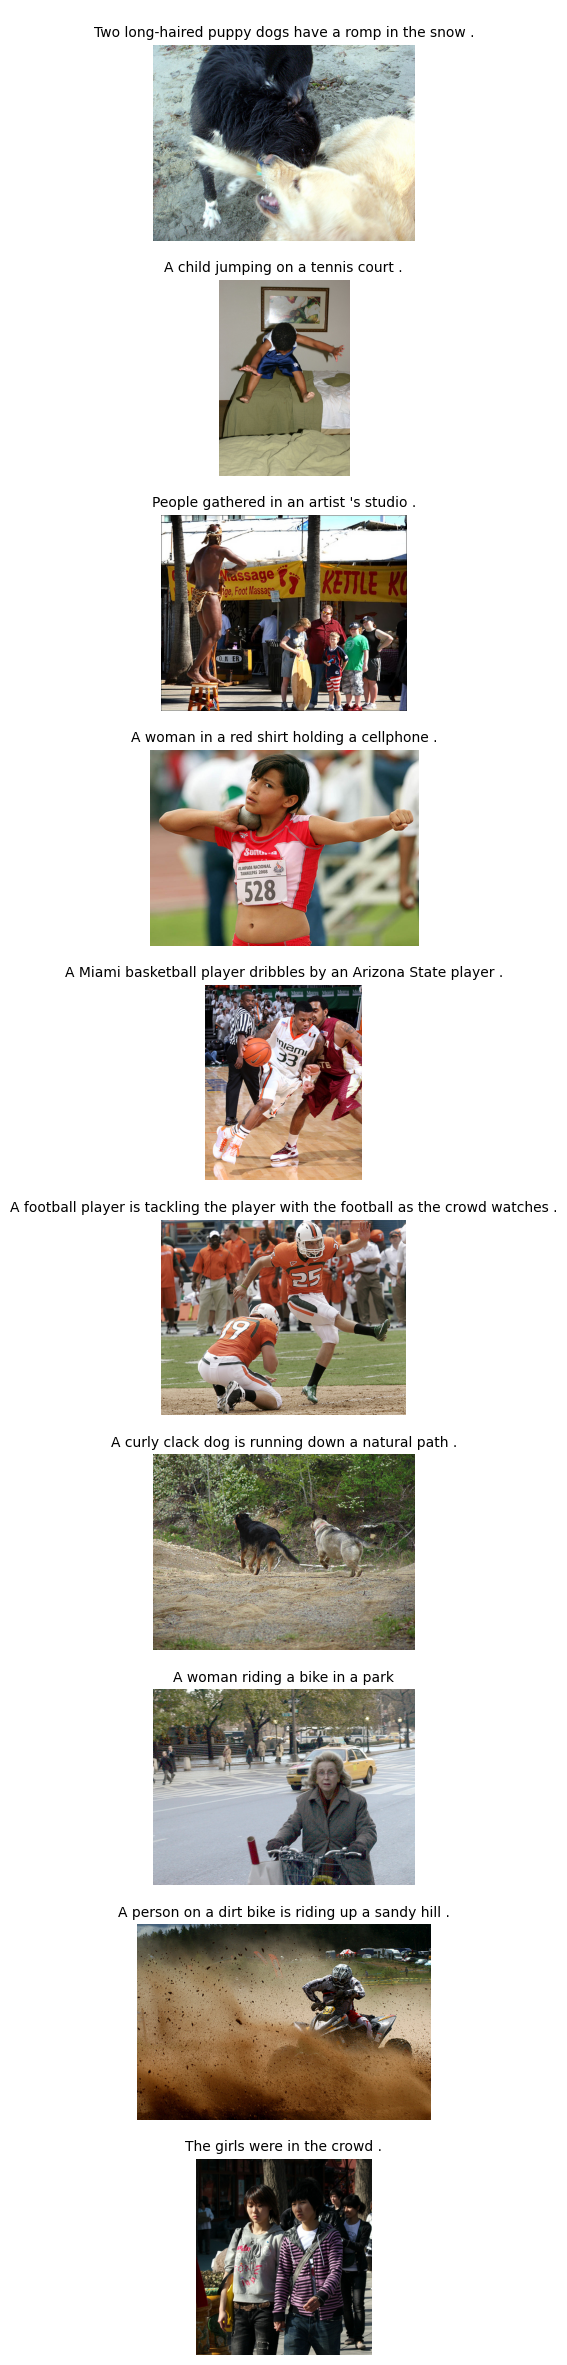

In [22]:
visual_dataset = train_dataset[train_dataset['positive'] > 0.5].sample(10).copy()
visual_dataset.reset_index(inplace=True)

images = []
labels = []

for i in range(visual_dataset.shape[0]):
    images.append(f'{TRAIN_IMAGE_FOLDER}/{visual_dataset.iloc[i]["image"]}')
    labels.append(visual_dataset.iloc[i]['query_text'])

image_show(images, labels)

## 2. Подготовка данных.

### 2.1 Стоп-слова.

Составим список слов, которые могут попадать под юридические ограничения, а именнно относящиеся к детям:

In [23]:
stop_words = [
    'baby',
    'child',
    'boy',
    'boys',
    'girl',
    'girls',
    'kid',
    'kids',
    'children'
]

Функция для определения стоп-слов в описании:

In [24]:
def ban(txt):
    txt = txt.lower()
    lemmatizer = WordNetLemmatizer()
    word_tokens = word_tokenize(txt)
    lemmatized_output = ' '.join([lemmatizer.lemmatize(w) for w in word_tokens])

    for word in stop_words:
        word_len = len(word.split())

        if word_len > 1:
            if word in txt:
                return True
        elif word_len == 1:
            if word in txt.split():
                return True

    return False

Определение записей со стоп-словами:

In [25]:
train_dataset['ban'] = train_dataset['query_text'].apply(ban)

In [26]:
train_dataset.head(10)

,,query_text,positive_crowd,mark_avg,positive_expert,positive,ban
image,query_id,,,,,,
1056338697_4f7d7ce270.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...,0.0,1.000000,0.000000,0.000000,True
1262583859_653f1469a9.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...,NaN,1.000000,0.000000,0.000000,True
2447284966_d6bbdb4b6e.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...,0.0,1.666667,0.000000,0.000000,True
2549968784_39bfbe44f9.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...,1.0,4.000000,1.000000,1.000000,True
2621415349_ef1a7e73be.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...,NaN,1.000000,0.000000,0.000000,True
3030566410_393c36a6c5.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...,0.0,2.333333,0.333333,0.333333,True
3155451946_c0862c70cb.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...,NaN,1.000000,0.000000,0.000000,True
3222041930_f642f49d28.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...,NaN,1.000000,0.000000,0.000000,True
343218198_1ca90e0734.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...,NaN,1.000000,0.000000,0.000000,True


Удаление записей со стоп-словами:

In [27]:
train_dataset.drop(train_dataset[train_dataset.ban == True].index, inplace=True)
train_dataset.drop(columns=['ban'], inplace=True)

In [28]:
train_dataset.head(10)

,,query_text,positive_crowd,mark_avg,positive_expert,positive
image,query_id,,,,,
1056338697_4f7d7ce270.jpg,3181701312_70a379ab6e.jpg#2,A man sleeps under a blanket on a city street .,NaN,1.333333,0.0,0.0
3187395715_f2940c2b72.jpg,3181701312_70a379ab6e.jpg#2,A man sleeps under a blanket on a city street .,NaN,1.666667,0.0,0.0
463978865_c87c6ca84c.jpg,3181701312_70a379ab6e.jpg#2,A man sleeps under a blanket on a city street .,0.0,2.000000,0.0,0.0
488590040_35a3e96c89.jpg,3181701312_70a379ab6e.jpg#2,A man sleeps under a blanket on a city street .,NaN,1.666667,0.0,0.0
534875358_6ea30d3091.jpg,3181701312_70a379ab6e.jpg#2,A man sleeps under a blanket on a city street .,NaN,1.333333,0.0,0.0
1056338697_4f7d7ce270.jpg,3207358897_bfa61fa3c6.jpg#2,A woman plays with long red ribbons in an empt...,NaN,1.666667,0.0,0.0
3208074567_ac44aeb3f3.jpg,3207358897_bfa61fa3c6.jpg#2,A woman plays with long red ribbons in an empt...,NaN,1.000000,0.0,0.0
3251976937_20625dc2b8.jpg,3207358897_bfa61fa3c6.jpg#2,A woman plays with long red ribbons in an empt...,NaN,1.000000,0.0,0.0
370713359_7560808550.jpg,3207358897_bfa61fa3c6.jpg#2,A woman plays with long red ribbons in an empt...,0.0,1.000000,0.0,0.0


### 2.2 Векторизация изображений.

In [29]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [30]:
# Использование модели ResNet50, предобученнной на Imagenet
weights = ResNet50_Weights.DEFAULT
model = resnet50(weights=weights)
model.to(device)
model.eval()

preprocess = weights.transforms(antialias=True)

return_nodes = {'flatten': 'flatten'}
feature_extractor = create_feature_extractor(model, return_nodes=return_nodes)

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:06<00:00, 15.1MB/s]


In [31]:
def get_image_vector(image_path):
    # Обработка изображения
    image = read_image(image_path).unsqueeze(0)
    model_input = preprocess(image).to(device)

    with torch.no_grad():
        features = feature_extractor(model_input)
        flatten_fts = features["flatten"].squeeze()
        return flatten_fts.to('cpu').detach().numpy()

In [32]:
# Словарь для хранения результатов обработки изображений
image_vectors = {}

def images2vector(folder):
    count = 0
    for p in Path(folder).glob('*.jpg'):
        count+=1
    with tqdm(total=count) as bar:
        for p in Path(folder).glob('*.jpg'):
            image_vectors[p.name] = get_image_vector(folder + f'/{p.name}')
            bar.update(1)

In [33]:
images2vector(TRAIN_IMAGE_FOLDER)

100%|██████████| 1000/1000 [03:12<00:00,  5.20it/s]


In [34]:
# Проверка размерности вектора
img1 = list(image_vectors.keys())[10]
print(f'Размерность вектора изображения {image_vectors[img1].shape[0]}')

Размерность вектора изображения 2048


### 2.3 Векторизация текстов.

In [35]:
# Использование легкой модели DistilBERT
tokenizer = AutoTokenizer.from_pretrained('distilbert-base-uncased')
model = AutoModel.from_pretrained('distilbert-base-uncased')
model.to(device)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

DistilBertModel(
  (embeddings): Embeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (transformer): Transformer(
    (layer): ModuleList(
      (0-5): 6 x TransformerBlock(
        (attention): DistilBertSdpaAttention(
          (dropout): Dropout(p=0.1, inplace=False)
          (q_lin): Linear(in_features=768, out_features=768, bias=True)
          (k_lin): Linear(in_features=768, out_features=768, bias=True)
          (v_lin): Linear(in_features=768, out_features=768, bias=True)
          (out_lin): Linear(in_features=768, out_features=768, bias=True)
        )
        (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
        (ffn): FFN(
          (dropout): Dropout(p=0.1, inplace=False)
          (lin1): Linear(in_features=768, out_features=3072, bias=True)
          (lin2): L

In [36]:
def mean_pooling(model_output, attention_mask):
    token_embeddings = model_output[0]
    input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
    sum_embeddings = torch.sum(token_embeddings * input_mask_expanded, 1)
    sum_mask = torch.clamp(input_mask_expanded.sum(1), min=1e-9)
    return sum_embeddings / sum_mask

In [37]:
# Функция для обработки строки запроса
def text2vector(sentences):
    encoded_input = tokenizer(sentences, padding=True, truncation=True, max_length=128, return_tensors='pt').to(device)

    with torch.no_grad():
        model_output = model(**encoded_input)
    sentence_embeddings = mean_pooling(model_output, encoded_input['attention_mask'])

    ar = sentence_embeddings[0].to('cpu').detach().numpy()
    return ar

In [38]:
# Создание векторов строк
train_dataset['text2vec'] = train_dataset['query_text'].apply(lambda x: text2vector(x))

In [39]:
print(f'Размерность вектора текста {train_dataset.iloc[0]["text2vec"].shape}')

Размерность вектора текста (768,)


In [40]:
train_dataset.head()

,,query_text,positive_crowd,mark_avg,positive_expert,positive,text2vec
image,query_id,,,,,,
1056338697_4f7d7ce270.jpg,3181701312_70a379ab6e.jpg#2,A man sleeps under a blanket on a city street .,NaN,1.333333,0.0,0.0,"[0.15153742, -0.09737309, -0.015055489, -0.024..."
3187395715_f2940c2b72.jpg,3181701312_70a379ab6e.jpg#2,A man sleeps under a blanket on a city street .,NaN,1.666667,0.0,0.0,"[0.15153742, -0.09737309, -0.015055489, -0.024..."
463978865_c87c6ca84c.jpg,3181701312_70a379ab6e.jpg#2,A man sleeps under a blanket on a city street .,0.0,2.000000,0.0,0.0,"[0.15153742, -0.09737309, -0.015055489, -0.024..."
488590040_35a3e96c89.jpg,3181701312_70a379ab6e.jpg#2,A man sleeps under a blanket on a city street .,NaN,1.666667,0.0,0.0,"[0.15153742, -0.09737309, -0.015055489, -0.024..."
534875358_6ea30d3091.jpg,3181701312_70a379ab6e.jpg#2,A man sleeps under a blanket on a city street .,NaN,1.333333,0.0,0.0,"[0.15153742, -0.09737309, -0.015055489, -0.024..."


### 2.4 Объединение векторов.

In [41]:
train_dataset.reset_index(inplace=True)

In [42]:
def image2vector(row):
    img = row['image']
    return image_vectors[img]

In [43]:
# Добавление векторов изображений в датафрейм
train_dataset['image2vec'] = train_dataset.apply(image2vector, axis=1)

In [44]:
# Конкатенация векторов
def join_vectors(row):
    return np.concatenate((row['text2vec'], row['image2vec']))

In [45]:
train_dataset['vec'] = train_dataset.apply(join_vectors, axis=1)

In [46]:
df = train_dataset.copy()

In [47]:
df.head()

,image,query_id,query_text,positive_crowd,mark_avg,positive_expert,positive,text2vec,image2vec,vec
0,1056338697_4f7d7ce270.jpg,3181701312_70a379ab6e.jpg#2,A man sleeps under a blanket on a city street .,NaN,1.333333,0.0,0.0,"[0.15153742, -0.09737309, -0.015055489, -0.024...","[0.55722123, 0.010324251, 0.05671981, 2.400107...","[0.15153742, -0.09737309, -0.015055489, -0.024..."
1,3187395715_f2940c2b72.jpg,3181701312_70a379ab6e.jpg#2,A man sleeps under a blanket on a city street .,NaN,1.666667,0.0,0.0,"[0.15153742, -0.09737309, -0.015055489, -0.024...","[0.13535734, 0.0, 0.014556022, 0.003579594, 0....","[0.15153742, -0.09737309, -0.015055489, -0.024..."
2,463978865_c87c6ca84c.jpg,3181701312_70a379ab6e.jpg#2,A man sleeps under a blanket on a city street .,0.0,2.000000,0.0,0.0,"[0.15153742, -0.09737309, -0.015055489, -0.024...","[0.043913636, 0.018463546, 0.0, 0.09001093, 0....","[0.15153742, -0.09737309, -0.015055489, -0.024..."
3,488590040_35a3e96c89.jpg,3181701312_70a379ab6e.jpg#2,A man sleeps under a blanket on a city street .,NaN,1.666667,0.0,0.0,"[0.15153742, -0.09737309, -0.015055489, -0.024...","[0.07001084, 0.0, 0.0, 0.031734917, 0.0, 0.041...","[0.15153742, -0.09737309, -0.015055489, -0.024..."
4,534875358_6ea30d3091.jpg,3181701312_70a379ab6e.jpg#2,A man sleeps under a blanket on a city street .,NaN,1.333333,0.0,0.0,"[0.15153742, -0.09737309, -0.015055489, -0.024...","[0.13674647, 0.0, 0.0, 0.10356048, 0.22423324,...","[0.15153742, -0.09737309, -0.015055489, -0.024..."


In [48]:
# Удаление записей без оценки
df.drop(df[df['positive'].isna()].index, inplace=True)
df = df.reset_index(drop=True)

In [49]:
print(f'Длина результирующего вектора: {len(df.iloc[0]["vec"])}.')

Длина результирующего вектора: 2816.


## 3. Обучение модели.

Разделение данных на тренировочную и тестовую выборки в пропорции 7:3 таким образом, что строки с одинаковым значением 'group_column' будут содержаться либо в тестовом, либо в тренировочном датасете.

In [50]:
gss = GroupShuffleSplit(n_splits=1, train_size=.7, random_state=RANDOM_STATE)
train_indices, test_indices = next(gss.split(X=df.drop(columns=['positive']), y=df['positive'], groups=df['image']))
train_df, test_df = df.loc[train_indices], df.loc[test_indices]

In [51]:
features_train = torch.FloatTensor(list(train_df.loc[:, 'vec'].values))
features_test = torch.FloatTensor(list(test_df.loc[:, 'vec'].values))

<ipython-input-51-74d94a739f06>:1: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  features_train = torch.FloatTensor(list(train_df.loc[:, 'vec'].values))


In [52]:
target_train = torch.FloatTensor(train_df['positive'].values).reshape(-1, 1)
target_test = torch.FloatTensor(test_df['positive'].values).reshape(-1, 1)

In [53]:
# Класс для масштабирования тензора
class TorchStandardScaler:
    def fit(self, x):
        self.mean = x.mean(0, keepdim=True)
        self.std = x.std(0, unbiased=False, keepdim=True)
    def transform(self, x):
        x -= self.mean
        x /= (self.std + 1e-7)
        return x

In [54]:
# Масштабирование данных
scaler = TorchStandardScaler()
scaler.fit(features_train)
features_train = scaler.transform(features_train)
features_test = scaler.transform(features_test)

### 3.1 Модель на основе линейной регрессии.

Для определения качества моделей будем использовать метрику RMSE. Она удобна тем, что минимизируется одновременно с MSE, которая дает хорошую скорость обучения нейронных сетей, и измеряется в тех же единицах, что и целевая переменная.

In [55]:
model_lr = LinearRegression()
model_lr.fit(features_train, target_train)

LinearRegression()

In [56]:
pred = model_lr.predict(features_test)
rmse_lr = (mean_squared_error(target_test, pred)) ** 0.5
print(f'RMSE для LinearRegression равно', round(rmse_lr, 3))

RMSE для LinearRegression равно 0.446


### 3.2 Полносвязная нейронная сеть.

In [57]:
# Создание датасета
class CustomDataset(Dataset):
    def __init__(self, features, target):
        self.features = features
        self.target = target

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        return self.features[idx], self.target[idx]

In [58]:
# Создание DataLoader
train_dataset = CustomDataset(features_train, target_train)
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)

test_dataset = CustomDataset(features_test, target_test)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=True)

In [59]:
# Проверка размерностей
train_features, train_labels = next(iter(train_dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")

Feature batch shape: torch.Size([32, 2816])
Labels batch shape: torch.Size([32, 1])


In [60]:
# Определение архитектуры нейронной сети
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(2816, 10240)
        self.fc2 = nn.Linear(10240, 4096)
        self.fc3 = nn.Linear(4096, 2048)
        self.fc4 = nn.Linear(2048, 512)
        self.fc5 = nn.Linear(512, 64)
        self.fc6 = nn.Linear(64, 1)

        self.dp = nn.Dropout(p=0.2)
        self.relu = nn.LeakyReLU()

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.dp(x)

        x = self.fc2(x)
        x = self.relu(x)
        x = self.dp(x)

        x = self.fc3(x)
        x = self.relu(x)
        x = self.dp(x)

        x = self.fc4(x)
        x = self.relu(x)
        x = self.dp(x)

        x = self.fc5(x)
        x = self.relu(x)
        x = self.dp(x)

        x = self.fc6(x)

        return x

Определение параметров обучения нейронной сети:

In [61]:
models = Net()
models.to(device)

criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(models.parameters(), lr=5e-6)

epochs = 5
min_valid_loss = np.inf

Обучение нейронной сети:

In [62]:
for e in range(epochs):
    train_loss = 0.0
    models.train()
    for data, labels in train_dataloader:
        data, labels = data.to(device), labels.to(device)

        optimizer.zero_grad()
        target = models(data)
        loss = torch.sqrt(criterion(target,labels))
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    valid_loss = 0.0
    models.eval()

    for data, labels in test_dataloader:
        data, labels = data.to(device), labels.to(device)

        target = models(data)
        loss = torch.sqrt(criterion(target, labels))
        valid_loss += loss.item()
    print(f'Epoch {e+1} \t\t Training Loss: {train_loss / len(train_dataloader)} \t\t Validation Loss: {valid_loss / len(test_dataloader)}')

Epoch 1 		 Training Loss: 0.35933256917878204 		 Validation Loss: 0.32033317014575
Epoch 2 		 Training Loss: 0.315298276825955 		 Validation Loss: 0.31598618552088736
Epoch 3 		 Training Loss: 0.30222053606259197 		 Validation Loss: 0.30475909151136876
Epoch 4 		 Training Loss: 0.28665121401611127 		 Validation Loss: 0.30312487185001374
Epoch 5 		 Training Loss: 0.26879954243961135 		 Validation Loss: 0.3055337380617857


## 4. Тестирование модели.

In [63]:
models.eval()

Net(
  (fc1): Linear(in_features=2816, out_features=10240, bias=True)
  (fc2): Linear(in_features=10240, out_features=4096, bias=True)
  (fc3): Linear(in_features=4096, out_features=2048, bias=True)
  (fc4): Linear(in_features=2048, out_features=512, bias=True)
  (fc5): Linear(in_features=512, out_features=64, bias=True)
  (fc6): Linear(in_features=64, out_features=1, bias=True)
  (dp): Dropout(p=0.2, inplace=False)
  (relu): LeakyReLU(negative_slope=0.01)
)

Загрузка списка тестовых изображений:

In [64]:
test_images_csv = pd.read_csv('/content/drive/MyDrive/overall_project_4/test_images.csv')
print(test_images_csv.info())
test_images_csv.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   image   100 non-null    object
dtypes: object(1)
memory usage: 932.0+ bytes
None


,image
0,3356748019_2251399314.jpg
1,2887171449_f54a2b9f39.jpg
2,3089107423_81a24eaf18.jpg
3,1429546659_44cb09cbe2.jpg
4,1177994172_10d143cb8d.jpg


Загрузка описаний для тестовых изображений:

In [65]:
test_queries_csv = pd.read_csv('/content/drive/MyDrive/overall_project_4/test_queries.csv',
                               sep='|', index_col=0)
test_queries_csv.info()
test_queries_csv.head()

<class 'pandas.core.frame.DataFrame'>
Index: 500 entries, 0 to 499
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   query_id    500 non-null    object
 1   query_text  500 non-null    object
 2   image       500 non-null    object
dtypes: object(3)
memory usage: 15.6+ KB


,query_id,query_text,image
0,1177994172_10d143cb8d.jpg#0,"Two blonde boys , one in a camouflage shirt an...",1177994172_10d143cb8d.jpg
1,1177994172_10d143cb8d.jpg#1,Two boys are squirting water guns at each other .,1177994172_10d143cb8d.jpg
2,1177994172_10d143cb8d.jpg#2,Two boys spraying each other with water,1177994172_10d143cb8d.jpg
3,1177994172_10d143cb8d.jpg#3,Two children wearing jeans squirt water at eac...,1177994172_10d143cb8d.jpg
4,1177994172_10d143cb8d.jpg#4,Two young boys are squirting water at each oth...,1177994172_10d143cb8d.jpg


In [66]:
image_vectors = {}
images2vector(TEST_IMAGE_FOLDER)

100%|██████████| 100/100 [00:18<00:00,  5.34it/s]


In [67]:
def search(txt):
    if ban(txt):
        return '/content/drive/MyDrive/overall_project_4/no_image_available.jpg', f'{txt}\nThis image is unavailable in your country in compliance with local laws.', None

    vec = text2vector(txt)

    data = []
    images = []

    for key in image_vectors.keys():
        images.append(key)

        img = image_vectors[key]
        data.append(np.concatenate((vec, img)))

    with torch.no_grad():
        pred = models(scaler.transform(torch.FloatTensor(data)).to(device)).to('cpu')
        # Индекс записи, которая больше всего подходит под описание
        idx = pred.numpy().argmax(axis=0)[0]

    return f'{TEST_IMAGE_FOLDER}/{images[idx]}', txt, pred[idx].numpy()[0]

In [68]:
# 10 случайных примеров из тестовых данных:
queries = list(test_queries_csv.sample(10, random_state=RANDOM_STATE)['query_text'])

In [69]:
images = []
labels = []
scores = []

for i in range(len(queries)):

    image_path, title, score = search(queries[i])

    images.append(image_path)
    if score == None:
        scores.append(None)
    else:
        scores.append(round(score, 3))
    labels.append(title)

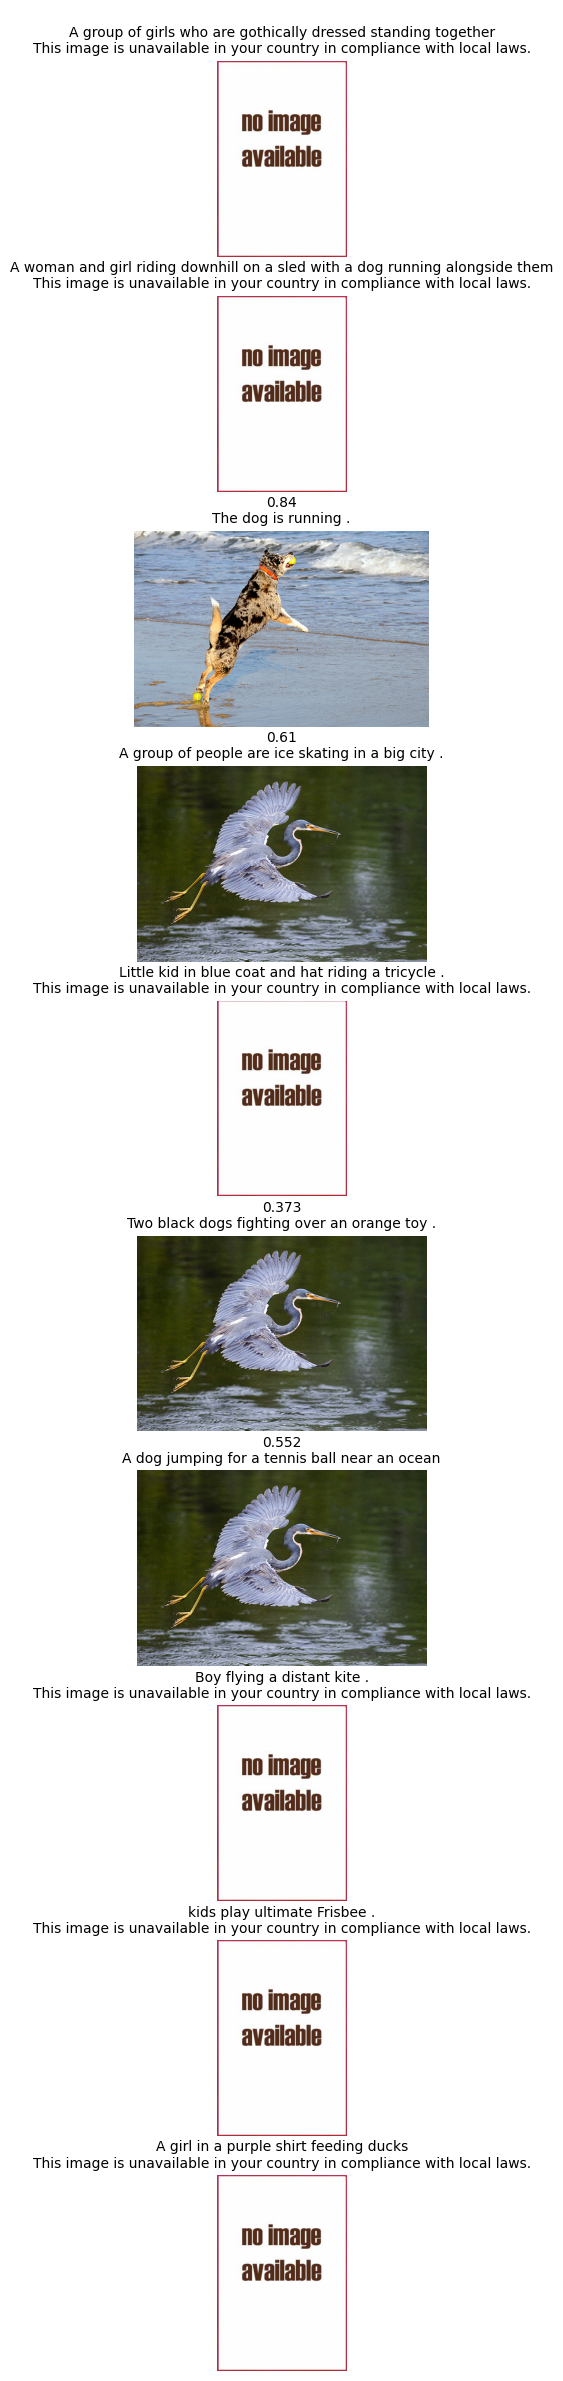

In [70]:
image_show(images, labels, scores)

# Выводы.
Для фотохостинга профессиональных фотографов «Со Смыслом» была разработана демонстрационная версию поиска изображений по запросу с учетом юридических ограничений. В ходе проекта:
- Из датасета исключены те объекты, которые выходят за рамки юридических ограничений.
- Изображения векторизованы.
- Текстовые запросы векторизованы.
- Данные разбиты на тренировочную и тестовую выборки.
- Предложена метрика качества работы модели - RMSE.
- Обучены модели на основе линейной регрессии и полносвязная нейронная сеть. Лучшие результаты показала нейронная сеть.
- Проведено тестирование работы модели.

Для улучшения качества модели требуется больше данных, также можно поэкспериментировать с архитектурой нейронной сети. Для определения контента, попадающего под юридические ограниченния, рекомендуется создать отдельную модель классификации.